In [72]:
import os 
import sys 
import random
import time

import numpy as np 
import pandas as pd
from typing import Any, Tuple 
import nltk
nltk.download('punkt')


import einops 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn import preprocessing 

random.seed(16)

import tensorflow as tf 
import tensorflow_text  as tf_text 

from Bio import pairwise2
from functools import partial
from collections import deque
import pathlib


use_builtins = True

import pickle as pkl 

[nltk_data] Downloading package punkt to /student/mrahbar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [73]:

##########################################################################################
# tf.config.experimental.set_memory_growth(physical_devices[0], True)


physical_devices = tf.config.list_physical_devices('GPU')
try:
    # Disable first GPU
    GPUs = tf.config.set_visible_devices(physical_devices[3], 'GPU')
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
    logical_devices = tf.config.list_logical_devices('GPU')

except:
    # Invalid device or cannot modify virtual devices once initialized.
    print("Invalid device or cannot modify virtual devices once initialized.")
    pass

##########################################################################################

In [74]:
train_path = os.path.join('data', 'train')
test_path = os.path.join('data', 'test')

In [75]:
# Word level 

with open(os.path.join(train_path, 'train-source.txt')) as f: 
    train_source = f.read()
    
with open(os.path.join(train_path, 'train-target.txt')) as f: 
    train_target = f.read()
    
train_source = train_source.split('</s>')
train_target = train_target.split('</s>')

for i in range(len(train_source)): 
    train_source[i] = str(train_source[i].lower()+'E').replace('<s>','S').strip().split('\n')
    train_target[i] = str(train_target[i].lower()+'E').replace('<s>','S').strip().split('\n')
    
    
    
with open(os.path.join(test_path, 'test-source.txt')) as f: 
    test_source = f.read()
    
with open(os.path.join(test_path, 'test-target.txt')) as f: 
    test_target = f.read()
    
test_source = test_source.split('</s>')
test_target = test_target.split('</s>')

for i in range(len(test_source)): 
    test_source[i] = str(test_source[i].lower()+'E').replace('<s>','S').strip().split('\n')
    test_target[i] = str(test_target[i].lower()+'E').replace('<s>','S').strip().split('\n')

In [76]:
# Word level 

with open(os.path.join(train_path, 'train-source.txt')) as f: 
    train_source = f.read()
    
with open(os.path.join(train_path, 'train-target.txt')) as f: 
    train_target = f.read()
    
train_source = train_source.strip().split('</s>')
train_target = train_target.strip().split('</s>')

for i in range(len(train_source)): 
    train_source[i] = str(train_source[i].lower()).replace('<s>','').strip().split('\n')
    train_target[i] = str(train_target[i].lower()).replace('<s>','').strip().split('\n')
    
    
    
with open(os.path.join(test_path, 'test-source.txt')) as f: 
    test_source = f.read()
    
with open(os.path.join(test_path, 'test-target.txt')) as f: 
    test_target = f.read()
    
test_source = test_source.split('</s>')
test_target = test_target.split('</s>')

for i in range(len(test_source)): 
    test_source[i] = str(test_source[i].lower()).replace('<s>','').strip().split('\n')
    test_target[i] = str(test_target[i].lower()).replace('<s>','').strip().split('\n')

In [77]:
test_source[0]

['scéal',
 'chathail',
 'freeman',
 '-',
 'téid',
 'mo',
 'dhearbhráthair',
 "'un",
 'na',
 'dubh-charraice']

In [78]:
train_source[1]

['(',
 'bhí',
 'sé',
 'follasach',
 'go',
 'rabh',
 'an',
 'poll',
 'sin',
 'ag',
 'foscladh',
 'ar',
 'an',
 'fhairrge',
 'ar',
 'dhóigh',
 'éigin',
 ',',
 'ná',
 'líonadh',
 'agus',
 'thráigheadh',
 'an',
 't-uisce',
 'ann',
 '.']

In [80]:
# Character level 

train_source_char = []
train_target_char = []

for i in range(len(train_source)): 
    train_source_char.append(' '.join(train_source[i]).replace('S','').replace('E','').lower().strip(' '))
    train_target_char.append(' '.join(train_target[i]).replace('S','').replace('E','').lower().strip(' '))
    
for i in range(len(train_source_char)):
    train_source_char[i] = [c for c in train_source_char[i]]
    train_target_char[i] = [c for c in train_target_char[i]] 
    
char_pool = [] 
for i in range(len(train_source_char)): 
    char_pool += train_source_char[i]+ train_target_char[i]  
    
    
# Character level - test set

test_source_char = []
test_target_char = []

for i in range(len(test_source)): 
    test_source_char.append(' '.join(test_source[i]).replace('S','').replace('E','').lower().strip(' '))
    test_target_char.append(' '.join(test_target[i]).replace('S','').replace('E','').lower().strip(' '))
    
for i in range(len(test_source_char)):
    test_source_char[i] = [c for c in test_source_char[i]]
    test_target_char[i] = [c for c in test_target_char[i]]
                                                                
                                                                
                                                                

In [81]:
len(set(char_pool))

77

In [82]:
def levenshtein_ratio_and_distance(s, t, ratio_calc = True):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
            

    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[rows-1][cols-1]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return distance[row][col]
    

    
    

In [83]:
def get_min(list1, list2): 
    if len(list1)< len(list2):
        return len(list1)
    else:
        return len(list2)

In [84]:
def get_max(list1, list2): 
    if len(list1)> len(list2):
        return len(list1)
    else:
        return len(list2)
    
def get_len(input_list):
    return len(input_list)

In [85]:
# c1 , c2  
def align_words(train_source):
    sentence_num = get_len(train_source)
    tagged_list = []
    for i in range(sentence_num): 
        c1, c2 = 0, 0 
        l1 = get_len(train_source[i])
        l2 = get_len(train_target[i])
        temp_tagged_list = []
        while c1<l1 and c2<l2-1:
            score_list = []
            for k in range(2):
                score_list.append(levenshtein_ratio_and_distance(train_source[i][c1], train_target[i][c2+k]))

            if c1<l1-1:
                score_list.append(levenshtein_ratio_and_distance(train_source[i][c1+1], train_target[i][c2]))
            if score_list[0]==1: 
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2]))
                c1 += 1 
                c2 += 1
            elif score_list[1]==1: 
                temp_tagged_list.append(("ε", train_target[i][c2]))
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2+1]))
                c1 += 1
                c2 += 2
            elif score_list[0]>0.4 and  score_list[1]>0.4:
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2+0]))
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2+1]))
                c1 += 1
                c2 += 2
            elif c1<l1-1 and score_list[0]>0.4 and  score_list[2]>0.4:
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2]))
                temp_tagged_list.append((train_source[i][c1+1], train_target[i][c2]))
                c1 += 2
                c2 += 1
            elif score_list[0]>0.3 and  score_list[1]<0.6:
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2+0]))
                c1 += 1
                c2 += 1
            elif score_list[0]<0.6 and  score_list[1]>0.3:
                temp_tagged_list.append(("ε", train_target[i][c2+k-1]))
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2+1]))
                c1 += 1
                c2 += 2
            else:
                temp_tagged_list.append((train_source[i][c1], "ε")) # <NULL> = ε
                c1 += 1

        tagged_list.append(temp_tagged_list)      
    return tagged_list
    
    

In [129]:
# c1 , c2  
def align_words(train_source, train_target):
    sentence_num = get_len(train_source)
    tagged_list = []
    for i in range(sentence_num): 
        c1, c2 = 0, 0 
        l1 = get_len(train_source[i])
        l2 = get_len(train_target[i])
        temp_tagged_list = []
        while c1<l1 and c2<l2-1:
            score_list = []
            for k in range(2):
                score_list.append(levenshtein_ratio_and_distance(train_source[i][c1], train_target[i][c2+k]))

            if c1<l1-1:
                score_list.append(levenshtein_ratio_and_distance(train_source[i][c1+1], train_target[i][c2]))
            if score_list[0]==1: 
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2]))
                c1 += 1 
                c2 += 1
            elif score_list[1]==1: 
                temp_tagged_list.append(("ε", train_target[i][c2]))
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2+1]))
                c1 += 1
                c2 += 2
            elif score_list[0]>0.4 and  score_list[1]>0.4:
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2+0]+ ' ' + train_target[i][c2+1]))
#                 temp_tagged_list.append((train_source[i][c1], train_target[i][c2+1]))
                c1 += 1
                c2 += 2
            elif c1<l1-1 and score_list[0]>0.4 and  score_list[2]>0.4:
                temp_tagged_list.append((train_source[i][c1]+ ' ' +train_source[i][c1+1], train_target[i][c2]))
#                 temp_tagged_list.append((train_source[i][c1+1], train_target[i][c2]))
                c1 += 2
                c2 += 1
            elif score_list[0]>0.4 and  score_list[1]<0.6:
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2+0]))
                c1 += 1
                c2 += 1
            elif score_list[0]<0.6 and  score_list[1]>0.4:
                temp_tagged_list.append(("ε", train_target[i][c2+k-1]))
                temp_tagged_list.append((train_source[i][c1], train_target[i][c2+1]))
                c1 += 1
                c2 += 2
            else:
                temp_tagged_list.append((train_source[i][c1], "ε")) # <NULL> = ε
                c1 += 1
#             temp_tagged_list.append((' ', ' '))
        
        tagged_list.append(temp_tagged_list[:-1])      
    return tagged_list
    
    

In [130]:
test_source[10]

['amuigh',
 'sa',
 'tír',
 'a',
 'bhí',
 'muid',
 "'n-ár",
 'gcomhnaidhe',
 ',',
 'agus',
 'ag',
 'gasúr',
 'cosamhail',
 'le',
 'mo',
 'dhearbhráthair',
 'ba',
 'doiligh',
 'áit',
 "'fhagháil",
 'a',
 "b'aoibhne",
 'ná',
 'an',
 'áit',
 "s'againne",
 '.']

In [131]:
tagged_list = align_words(train_source, train_target)
tagged_list_test = align_words(test_source, test_target)

In [95]:
tagged_list[0]

[('cinnte', 'cinnte'),
 ('go', 'go'),
 ('leór', 'leor'),
 (',', ','),
 ('thiocfadh', 'thiocfadh'),
 ('dóbhtha', 'dóibh'),
 ('bás', 'bás'),
 ('a', 'a'),
 ('fhagháil', 'fháil'),
 ('ar', 'ar'),
 ('imeall', 'imeall'),
 ('an', 'an'),
 ('phuill', 'phoill')]

In [93]:
tagged_list_test[:3]

[('scéal', 'scéal'), ('chathail', 'chathail'), ('freeman', 'freeman')]

In [45]:
def pad(input_string, max_len):
    input_string += "ε" * (max_len - len(input_string))
    return input_string
        

In [46]:
def pad_list(sentence_list):
    padded_sentence_list = [] 
    for i in range(len(sentence_list)):
        
        if len(sentence_list[i][0])>len(sentence_list[i][1]):
            max_len = len(sentence_list[i][0])
        else: 
            max_len = len(sentence_list[i][1])
        padded_sentence_list.append((pad(sentence_list[i][0], max_len),
                                 pad(sentence_list[i][1], max_len)))
    return padded_sentence_list
            

In [47]:
padded_list = pad_list(tagged_list)
padded_list_test = pad_list(tagged_list_test)

In [48]:
def make_char_pair_set(sent_word_list:list): 
    sent_word_char_list = [] 
    for i in range(len(sent_word_list)):
        string_list = []
        for k in range(len(sent_word_list[i][0])):
            string_list.append((sent_word_list[i][0][k], sent_word_list[i][1][k]))
        string_list.append((' ', ' '))
        sent_word_char_list.append(string_list)
    return sent_word_char_list  
            

In [49]:
padded_char_list = make_char_pair_set(padded_list)
padded_char_list_test = make_char_pair_set(padded_list_test)

In [50]:
padded_char_list[0] 

[('c', 'c'),
 ('i', 'i'),
 ('n', 'n'),
 ('n', 'n'),
 ('t', 't'),
 ('e', 'e'),
 (' ', ' ')]

In [51]:
sentence_list_train = padded_char_list
sentence_list_test = padded_char_list_test
global_list_of_words = [w for sentence in sentence_list_train for w,t in sentence]
# global_list_of_chars 
# global_list_of_tags 

In [52]:
Xy_train, Xy_test = (sentence_list_train, sentence_list_test)

In [ ]:
train_tagged_words = [ tup for sent in Xy_train for tup in sent]
test_tagged_words = [ tup for sent in Xy_test for tup in sent]
print(len(train_tagged_words))
print(len(test_tagged_words))

In [ ]:
#use set datatype to check how many unique tags are present in training data
tags = {tag for word,tag in train_tagged_words}
# print(len(tags))
print(tags)
 
# check total words in vocabulary
vocab = {word for word,tag in train_tagged_words}

## References: 
### Using an attention-based sequence to sequence encoder decoder
1. https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [ ]:
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

In [133]:
tagged_list[0]

[('cinnte', 'cinnte'),
 ('go', 'go'),
 ('leór', 'leor'),
 (',', ','),
 ('thiocfadh', 'thiocfadh'),
 ('dóbhtha', 'dóibh'),
 ('bás', 'bás'),
 ('a', 'a'),
 ('fhagháil', 'fháil'),
 ('ar', 'ar'),
 ('imeall', 'imeall'),
 ('an', 'an'),
 ('phuill', 'phoill'),
 ('udaí', 'ε'),
 ('ε', 'úd')]

In [134]:
def load_data(tagged_list):
    context = [] 
    target = [] 
    for i in range(len(tagged_list)-1):
        temp_context = [] 
        temp_target = [] 
        for j in range(len(tagged_list[i])): 
            temp_context.append(tagged_list[i][j][0])
            temp_target.append(tagged_list[i][j][1])
        context.append(temp_context)
        target.append(temp_target)
        
    for i in range(len(context)):
        context[i] = " ".join(context[i])
        target[i] = " ".join(target[i])

    return target, context

In [135]:
target_raw, context_raw = load_data(tagged_list)
print(context_raw[-1])
print(target_raw[-1])

mar sin de , caithfidh mé suidhe sa
mar sin de , caithfidh mé suí sa


In [143]:
np.array(context_raw[0])

array('cinnte go leór , thiocfadh dóbhtha bás a fhagháil ar imeall an phuill udaí ε',
      dtype='<U76')

In [142]:
len(is_train)

45171

In [248]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 32

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

context_raw_train = []
target_raw_train = []  
context_raw_val = []
target_raw_val = []
for i in range(len(is_train)):
    if is_train[i]: 
        context_raw_train.append(context_raw[i])
        target_raw_train.append(target_raw[i])
    else:
        context_raw_val.append(context_raw[i])
        target_raw_val.append(target_raw[i])
        

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw_train, target_raw_train))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw_val, target_raw_val))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [249]:
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

tf.Tensor(
[b"shiubhail t\xc3\xba cuid mhaith de do th\xc3\xadr dh\xc3\xbathchais agus p\xc3\xa1irt mh\xc3\xb3r de'n d\xc3\xa1 oile\xc3\xa1n is deise"
 b'" ar mheas ? " arsa jukes leis'
 b'carr\xc3\xb3ir a bh\xc3\xad ag gabh\xc3\xa1il s\xc3\xados go doire an l\xc3\xa1 roimh r\xc3\xa9 \xce\xb5 thug s\xc3\xa9 leis a gcuid bag\xc3\xa1ist\xc3\xad ; agus \xce\xb5 anois nuair nach raibh aon ualach le h-iomchar \xce\xb5 n\xc3\xador sh\xc3\xadl siad a dhath de s\xc3\xa9 mh\xc3\xadle dh\xc3\xa9ag agus fiche de astar a dh\xc3\xa9anamh go dt\xc3\xad an'
 b"' s\xc3\xa9a'r'd a b'fhearr linn \xce\xb5 \xc3\xa9 bheith ' \xce\xb5 na dhrabhlas cosamhail \xce\xb5 linn fh\xc3\xa9in"
 b'" \xce\xb5 n\xc3\xad dheachaidh drod ar a bh\xc3\xa9al an oidhche f\xc3\xa1 dheireadh ach ag cainnt ar'], shape=(5,), dtype=string)

tf.Tensor(
[b'shi\xc3\xbail t\xc3\xba cuid mhaith de do th\xc3\xadr dh\xc3\xbachais agus p\xc3\xa1irt mh\xc3\xb3r den d\xc3\xa1 oile\xc3\xa1n is deise'
 b'" ar mheas ? " arsa jukes leis'
 b"ca

In [250]:
example_text = tf.constant('saoghal ion-mhaoidhte orainn sa bhaile')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'saoghal ion-mhaoidhte orainn sa bhaile'
b'saoghal ion-mhaoidhte orainn sa bhaile'


In [251]:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [252]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

saoghal ion-mhaoidhte orainn sa bhaile
[START] saoghal ion-mhaoidhte orainn sa bhaile [END]


In [253]:
max_vocab_size = 10000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [254]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'a', 'ε', 'an', ',', 'agus', 'ar']

In [255]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'ε', '[START]', '[END]', 'a', 'an', ',', 'agus', 'ar']

In [256]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 303, 58, 125, 130, 31, 39, 766, 5482, 8, 2707, 115, 94, 59, 708, 45,
  909, 3]                                                                ,
 [2, 11, 9, 978, 85, 11, 22, 402, 30, 3],
 [2, 4117, 4, 10, 15, 228, 122, 14, 1659, 6, 61, 334, 1919, 5, 68, 13, 30,
  4, 213, 1, 66, 8, 5, 97, 35, 32, 62, 95, 1839, 20, 6102, 5, 74, 383, 33,
  4, 198, 31, 13, 1015, 1875, 8, 398, 31, 3329, 4, 181, 14, 109, 6, 3]    ]>

In [257]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

"[START] shiubhail tú cuid mhaith de do thír dhúthchais agus páirt mhór de'n dá oileán is deise [END]"

In [258]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [259]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy()) 

[   2  303   13   14 2842    9  643   12 1575    7]

[   3  284   12   13 2682    9  619   14 1483    7]
[ 284   12   13 2682    9  619   14 1483    7    8]


In [260]:
UNITS = 128

In [261]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                                   mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                # Return the sequence and state
                                return_sequences=True,
                                recurrent_initializer='glorot_uniform'))

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [262]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (32, 46)
Encoder output, shape (batch, s, units): (32, 46, 128)


In [263]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = ShapeChecker()

        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)
    
        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [264]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (32, 46, 128)
Target sequence, shape (batch, t, units): (32, 45, 128)
Attention result, shape (batch, t, units): (32, 45, 128)
Attention weights, shape (batch, t, s):    (32, 45, 46)


In [265]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 0.99999994, 1.        , 0.99999994,
       1.        , 0.99999994, 0.99999994, 1.        , 1.        ,
       1.0000001 , 1.        , 0.99999994, 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 0.99999994, 1.        , 0.99999994,
       1.        , 0.9999999 , 1.        , 1.        , 0.99999994,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)

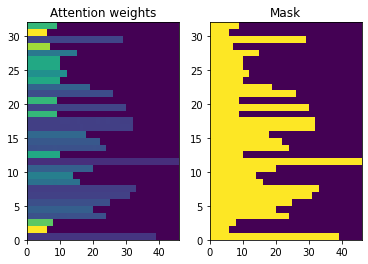

In [266]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [267]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

    
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits

In [268]:
decoder = Decoder(target_text_processor, UNITS)

In [269]:
logits = decoder(ex_context, ex_tar_in)
print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (32, 46, 128)
input target tokens shape: (batch, t) (32, 45)
logits shape shape: (batch, target_vocabulary_size) (32, 45, 10000)


In [270]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [271]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

In [272]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [273]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'oirne\xcc\x81ise gallcho\xcc\x81ir bhocht deirimse gcluine gloini\xcc\x81 deilbh mhaoil grabhar locha\xcc\x81in',
       b"mb'fhe\xcc\x81idir osrai\xcc\x81 glagaireacht throime mholl leathcheann bui\xcc\x81 'deir achrann chreid",
       b'leithsce\xcc\x81al di\xcc\x81omsa dochartaigh chreagacha sca\xcc\x81tha nde\xcc\x81ana sto\xcc\x81pa t-athairlus le\xcc\x81ine ni\xcc\x81n'],
      dtype=object)

In [276]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
                context_text_processor,
                target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        #TODO(b/250038731): remove this
        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [277]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))



In [278]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [279]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [280]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [281]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 9.2103405, 'expected_acc': 0.0001}

In [282]:
val_ds

<ParallelMapDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [283]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 7s 44ms/step - loss: 9.2104 - masked_acc: 1.0000e-04 - masked_loss: 9.2104


{'loss': 9.210420608520508,
 'masked_acc': 0.00010000000474974513,
 'masked_loss': 9.210420608520508}

In [284]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 27s 80ms/step - loss: 6.3586 - masked_acc: 0.0854 - masked_loss: 6.3586 - val_loss: 5.7394 - val_masked_acc: 0.1163 - val_masked_loss: 5.7394
Epoch 2/100
100/100 [==============================] - 8s 77ms/step - loss: 5.5302 - masked_acc: 0.1426 - masked_loss: 5.5302 - val_loss: 5.0802 - val_masked_acc: 0.1848 - val_masked_loss: 5.0802
Epoch 3/100
100/100 [==============================] - 8s 78ms/step - loss: 4.9482 - masked_acc: 0.2152 - masked_loss: 4.9482 - val_loss: 4.5962 - val_masked_acc: 0.2519 - val_masked_loss: 4.5962
Epoch 4/100
100/100 [==============================] - 8s 78ms/step - loss: 4.4745 - masked_acc: 0.2821 - masked_loss: 4.4745 - val_loss: 4.0974 - val_masked_acc: 0.3295 - val_masked_loss: 4.0974
Epoch 5/100
100/100 [==============================] - 8s 77ms/step - loss: 3.7101 - masked_acc: 0.4146 - masked_loss: 3.7101 - val_loss: 3.1469 - val_masked_acc: 0.4986 - val_masked_loss: 3.1469
Epoch 6/100
100/100

In [286]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)
        
        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [287]:
test_source, test_target = load_data(tagged_list_test)

In [288]:
result = [] 
total = 0
for i in range(len(test_source)):
    result.append(model.translate([test_source[i]])[0].numpy().decode())
    total += nltk.translate.bleu_score.sentence_bleu([test_target[i]], result[-1], weights=[1])
print(total/len(test_source))
    

0.7095056302491874
